## Intro

This is a brief exploration into the Telco Customer Churn data found on Kaggle:

https://www.kaggle.com/blastchar/telco-customer-churn

The idea is to predict behaviour in retaining customers.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tqdm import tqdm
import statsmodels.api as sma
from collections import Counter
import seaborn as sns

%matplotlib inline

Lets take an initial look at the data set. Its relatively small compared to *real world examples*.

### Data Dive

In [2]:
df = pd.read_csv(r'data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col=0)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


C:\Users\schillw\AppData\Local\Continuum\anaconda3\envs\fnb\lib\site-packages\pandas\plotting\_core.py:1729: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


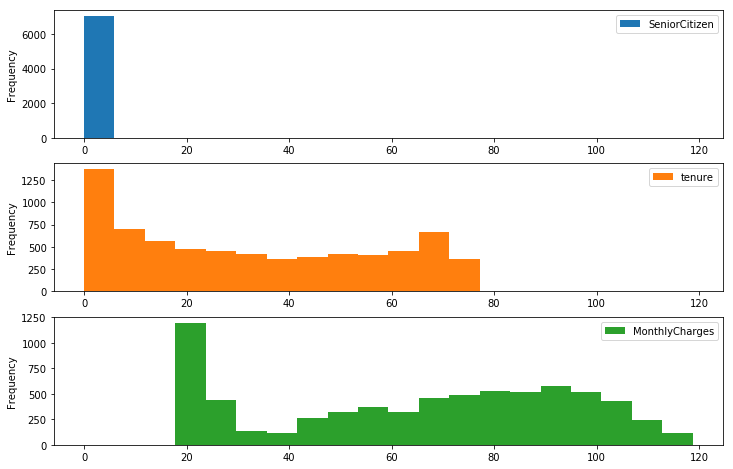

In [11]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
df[['SeniorCitizen','tenure','MonthlyCharges']].plot(kind='hist', subplots=True, ax=ax, bins=20);

- The *SeniorCitizen* category is a little confusing.
- The distribution of the tenure highlights that most customers have a lower tenure.
- The distribution of the Monthly Charges shows two clear hills, at charges around \\$20 and also from \\$65 - \\$100. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


So here we see that we have 17 columns registered as object or that could potentially be categorical.

In [62]:
binary_cols = []
dummy_cols = []
for oc in df.select_dtypes(include='object'):
    ctr = Counter(df[str(oc)])
    if len(ctr) < 3:
        binary_cols.append(oc)
        print("Binary or Oridinal: ",oc, '->', ctr, '\n')
    if (len(ctr) >= 3) & (len(ctr) < 10):
        dummy_cols.append(oc)
        print("Categorical Dummy : ", oc, '->', ctr, '\n')
    if len(ctr) > 10:
        print("\t More than 10 Unique Values :", oc, '\n')

Binary or Oridinal:  gender -> Counter({'Male': 3555, 'Female': 3488}) 

Binary or Oridinal:  Partner -> Counter({'No': 3641, 'Yes': 3402}) 

Binary or Oridinal:  Dependents -> Counter({'No': 4933, 'Yes': 2110}) 

Binary or Oridinal:  PhoneService -> Counter({'Yes': 6361, 'No': 682}) 

Categorical Dummy :  MultipleLines -> Counter({'No': 3390, 'Yes': 2971, 'No phone service': 682}) 

Categorical Dummy :  InternetService -> Counter({'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}) 

Categorical Dummy :  OnlineSecurity -> Counter({'No': 3498, 'Yes': 2019, 'No internet service': 1526}) 

Categorical Dummy :  OnlineBackup -> Counter({'No': 3088, 'Yes': 2429, 'No internet service': 1526}) 

Categorical Dummy :  DeviceProtection -> Counter({'No': 3095, 'Yes': 2422, 'No internet service': 1526}) 

Categorical Dummy :  TechSupport -> Counter({'No': 3473, 'Yes': 2044, 'No internet service': 1526}) 

Categorical Dummy :  StreamingTV -> Counter({'No': 2810, 'Yes': 2707, 'No internet service': 1526}

It seems that most of these can be dummied fairly easily with the exception of Total Charges. We will have to examine this column in further detail below.

By a quick glance it appears that there are not any severe distributions of the categorical values. This data is really clean already.


In [12]:
df['TotalCharges'].head(20)

customerID
7590-VHVEG      29.85
5575-GNVDE     1889.5
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
9305-CDSKC      820.5
1452-KIOVK     1949.4
6713-OKOMC      301.9
7892-POOKP    3046.05
6388-TABGU    3487.95
9763-GRSKD     587.45
7469-LKBCI      326.8
8091-TTVAX     5681.1
0280-XJGEX     5036.3
5129-JLPIS    2686.05
3655-SNQYZ    7895.15
8191-XWSZG    1022.95
9959-WOFKT    7382.25
4190-MFLUW     528.35
4183-MYFRB     1862.9
Name: TotalCharges, dtype: object

This column looks like its mislabeled as an object and there may be some items in it causing it not to be registered as float.

In [22]:
# for i in df['TotalCharges']:
#     try:
#         df['TotalCharges'][i].astype('float64')
#     except:
#         print(df['TotalCharges'][i])

float(df['TotalCharges'][0])

29.85

In [30]:
tc_new = []
for i in range(len(df['TotalCharges'])):
    try:
        tc_new.append(float(df['TotalCharges'].iloc[i]))
    except:
        print('anyone home? - ', df['TotalCharges'].iloc[i])
        tc_new.append(np.nan)

anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   
anyone home? -   


In [29]:
print(df.shape, len(tc_new))

(7043, 20) 7043


It looks like we have worked all the strings out to be floats and the ones that wouldnt convert were empty so theyve been replaced with **np.nan** .

In [31]:
df['TotalCharges'] = tc_new

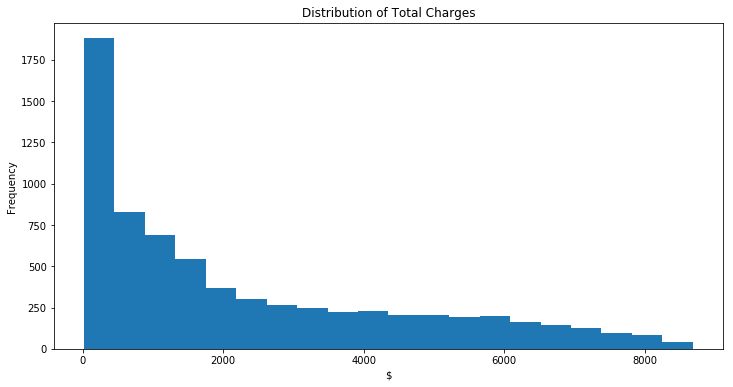

In [39]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
# sns.distplot(df['TotalCharges'].fillna(0),ax=ax, norm_hist=True);
df["TotalCharges"].plot(kind='hist', ax=ax, bins=20);
plt.title("Distribution of Total Charges");
plt.xlabel('$');

Kind of in the shape of Poisson distribution, there are many more low charges than higher ones.

### Examining Churn

The last part before we do some modeling is we will take a look at the churn target.

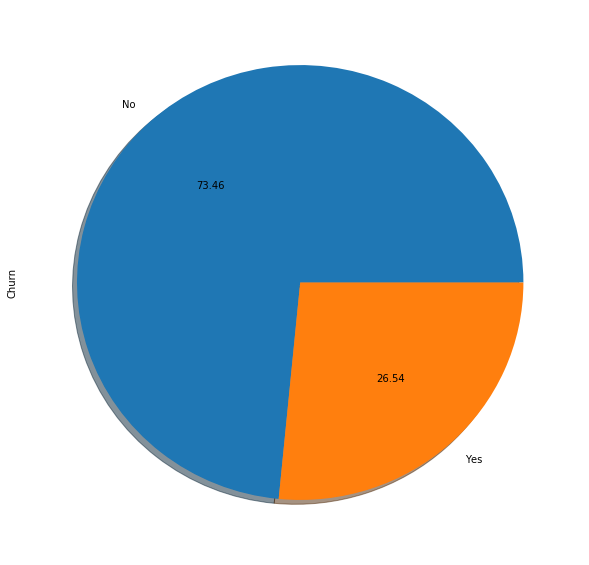

In [55]:
fig, ax=plt.subplots(1,1,figsize=(10,10))
df['Churn'].value_counts().plot(ax=ax, kind='pie', autopct='%.2f',shadow=True);

So here we have that **26.54**% of the target is labeled as a positive for churn. This is a fairly good distribution and may not need further re-balancing.

### PreProcessing for Modeling

- Convert all the object columns to dummies.
- Standardize all of the float columns.

In [109]:
df0 = df.copy()

THe best practices here are up to opinion but I am going to factorize the columns with less than 3 "categories".

In [110]:
for c in binary_cols:
    df0[c], uniqs = pd.factorize(df0[c])
#     print(uniqs)

In [111]:
print(binary_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


And here we will dummy those with more than 3.

In [112]:
for c in dummy_cols:
    chk = pd.get_dummies(df0[c])
    print(chk.head())
    
    df0 = df0.join(chk, how='outer', rsuffix=str('_'+c))
    df0.drop([c],axis=1,inplace=True)

            No  No phone service  Yes
customerID                           
7590-VHVEG   0                 1    0
5575-GNVDE   1                 0    0
3668-QPYBK   1                 0    0
7795-CFOCW   0                 1    0
9237-HQITU   1                 0    0
            DSL  Fiber optic  No
customerID                      
7590-VHVEG    1            0   0
5575-GNVDE    1            0   0
3668-QPYBK    1            0   0
7795-CFOCW    1            0   0
9237-HQITU    0            1   0
            No  No internet service  Yes
customerID                              
7590-VHVEG   1                    0    0
5575-GNVDE   0                    0    1
3668-QPYBK   0                    0    1
7795-CFOCW   0                    0    1
9237-HQITU   1                    0    0
            No  No internet service  Yes
customerID                              
7590-VHVEG   0                    0    1
5575-GNVDE   1                    0    0
3668-QPYBK   0                    0    1
7795-CFOCW 

In [113]:
for c in df0.columns:
    print(c)

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
PaperlessBilling
MonthlyCharges
TotalCharges
Churn
No
No phone service
Yes
DSL
Fiber optic
No_InternetService
No_OnlineSecurity
No internet service
Yes_OnlineSecurity
No_OnlineBackup
No internet service_OnlineBackup
Yes_OnlineBackup
No_DeviceProtection
No internet service_DeviceProtection
Yes_DeviceProtection
No_TechSupport
No internet service_TechSupport
Yes_TechSupport
No_StreamingTV
No internet service_StreamingTV
Yes_StreamingTV
No_StreamingMovies
No internet service_StreamingMovies
Yes_StreamingMovies
Month-to-month
One year
Two year
Bank transfer (automatic)
Credit card (automatic)
Electronic check
Mailed check


In [114]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 41 columns):
gender                                  7043 non-null int64
SeniorCitizen                           7043 non-null int64
Partner                                 7043 non-null int64
Dependents                              7043 non-null int64
tenure                                  7043 non-null int64
PhoneService                            7043 non-null int64
PaperlessBilling                        7043 non-null int64
MonthlyCharges                          7043 non-null float64
TotalCharges                            7032 non-null float64
Churn                                   7043 non-null int64
No                                      7043 non-null uint8
No phone service                        7043 non-null uint8
Yes                                     7043 non-null uint8
DSL                                     7043 non-null uint8
Fiber optic                            

So we have converted all the columns.

In [115]:
#missing data
total = df0.isnull().sum().sort_values(ascending=False)
percent = (df0.isnull().sum()/df0.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
TotalCharges,11,0.001562
Mailed check,0,0.000000
No,0,0.000000
No internet service,0,0.000000
No_OnlineSecurity,0,0.000000
No_InternetService,0,0.000000


It looks like just a few point are missing, so we will fill the Total Charges with 0's

In [116]:
df0['TotalCharges'] = df['TotalCharges'].fillna(0)

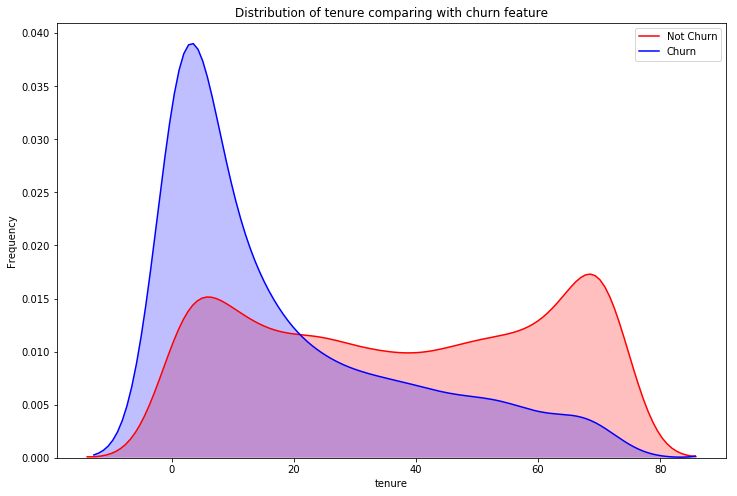

In [117]:
# tenure distibution 
fig, ax=plt.subplots(1,1,figsize=(12,8))
g = sns.kdeplot(df0.tenure[(df0["Churn"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(df0.tenure[(df0["Churn"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("tenure")
g.set_ylabel("Frequency")
plt.title('Distribution of tenure comparing with churn feature')
g = g.legend(["Not Churn","Churn"])

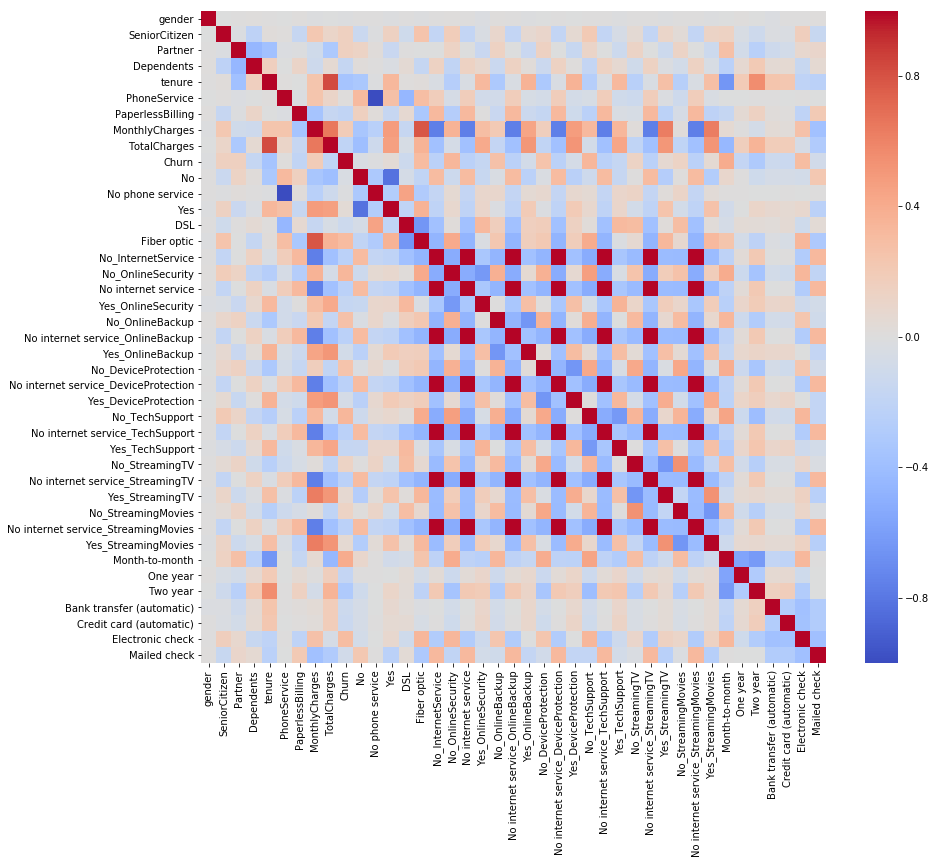

In [118]:
fig, ax=plt.subplots(1,1,figsize=(14,12))
sns.heatmap(df0.corr(), vmin=-1, vmax=1, cmap='coolwarm');

In [119]:
continuous_data = df0[['tenure','MonthlyCharges','TotalCharges','Churn']]

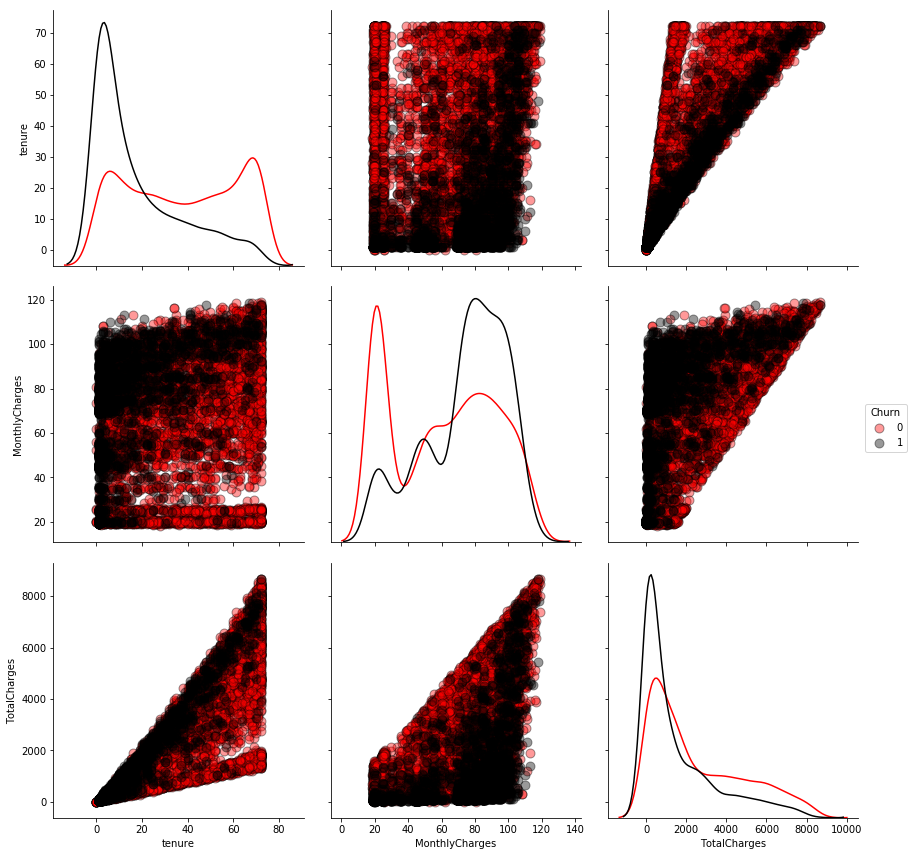

In [120]:
g = sns.pairplot(continuous_data, 
                vars = ['tenure','MonthlyCharges','TotalCharges'], 
                 hue="Churn", diag_kind = 'kde', 
             plot_kws = {'alpha': 0.4, 's': 80, 'edgecolor': 'k'},
                 palette = ['red','k'],
             size = 4);

## Feature Engineering

Here will create a few features based on some uneducated insights.

In [121]:
df0['TotalperTenure'] = df0['TotalCharges'] / df0['tenure']
## Total dolalrs per tenure. Chance for there to be NaN and Inf Values here
## will have to correct it at the end

C:\Users\schillw\AppData\Local\Continuum\anaconda3\envs\fnb\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\schillw\AppData\Local\Continuum\anaconda3\envs\fnb\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


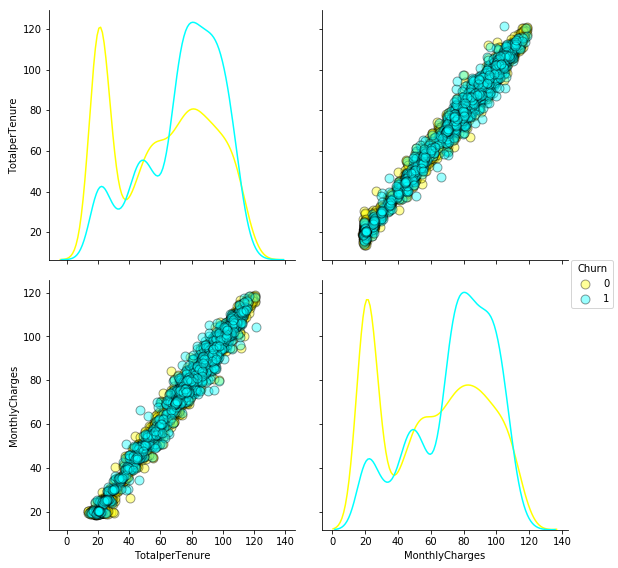

In [125]:
g = sns.pairplot(df0, 
                vars = ['TotalperTenure','MonthlyCharges'], 
                 hue="Churn", diag_kind = 'kde', 
             plot_kws = {'alpha': 0.4, 's': 80, 'edgecolor': 'k'},
                 palette = ['yellow','cyan'],
             size = 4);

In [126]:
df0['Change_Monthly_Plan'] = abs(df0['TotalperTenure'] - df0['MonthlyCharges'])
df0['Change_Monthly_Plan'] = df0['Change_Monthly_Plan'].map(lambda s :1  if s > 2 else 0)

## Monthly plan changes

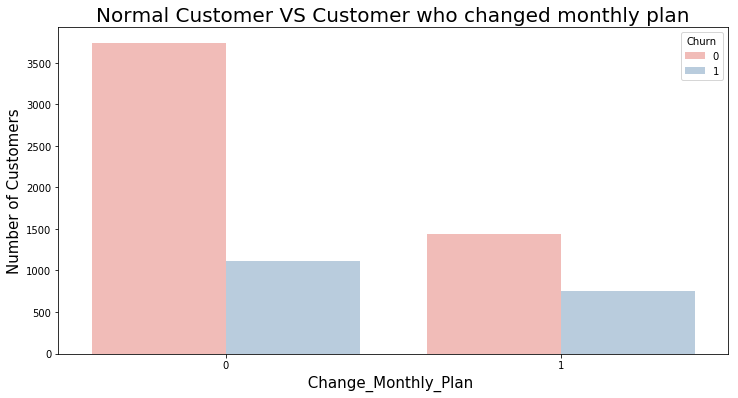

In [127]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Change_Monthly_Plan", hue="Churn", data=df0 , palette = "Pastel1");
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.set_xlabel(' Change_Monthly_Plan  ', fontsize = 15)

ax.set_title('Normal Customer VS Customer who changed monthly plan', fontsize=20);

## Check the Target

In [128]:
y = df0.Churn

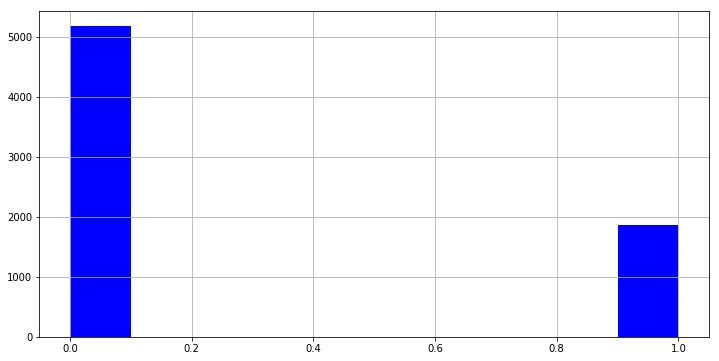

In [129]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
# sns.distplot(y, ax=ax);
y.hist(ax=ax, color='b');

In [130]:
cnt_y = Counter(y)
print(cnt_y, 'Churn to Non Churn Ratio: {:.4f}'.format(cnt_y[1]/cnt_y[0]))

Counter({0: 5174, 1: 1869}) Churn to Non Churn Ratio: 0.3612


In [131]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 43 columns):
gender                                  7043 non-null int64
SeniorCitizen                           7043 non-null int64
Partner                                 7043 non-null int64
Dependents                              7043 non-null int64
tenure                                  7043 non-null int64
PhoneService                            7043 non-null int64
PaperlessBilling                        7043 non-null int64
MonthlyCharges                          7043 non-null float64
TotalCharges                            7043 non-null float64
Churn                                   7043 non-null int64
No                                      7043 non-null uint8
No phone service                        7043 non-null uint8
Yes                                     7043 non-null uint8
DSL                                     7043 non-null uint8
Fiber optic                            

In [132]:
ss = StandardScaler()

In [135]:
np.isnan(df0['TotalperTenure']).sum()

11

In [136]:
df0['TotalperTenure'] = df0['TotalperTenure'].replace(np.inf,0)
df0['TotalperTenure'] = df0['TotalperTenure'].replace(-np.inf,0)

np.isinf(df0['TotalperTenure']).sum()

0

In [138]:
for c in df0.columns:
    print(c)
    print(np.isinf(df0[c]).sum())

gender
0
SeniorCitizen
0
Partner
0
Dependents
0
tenure
0
PhoneService
0
PaperlessBilling
0
MonthlyCharges
0
TotalCharges
0
Churn
0
No
0
No phone service
0
Yes
0
DSL
0
Fiber optic
0
No_InternetService
0
No_OnlineSecurity
0
No internet service
0
Yes_OnlineSecurity
0
No_OnlineBackup
0
No internet service_OnlineBackup
0
Yes_OnlineBackup
0
No_DeviceProtection
0
No internet service_DeviceProtection
0
Yes_DeviceProtection
0
No_TechSupport
0
No internet service_TechSupport
0
Yes_TechSupport
0
No_StreamingTV
0
No internet service_StreamingTV
0
Yes_StreamingTV
0
No_StreamingMovies
0
No internet service_StreamingMovies
0
Yes_StreamingMovies
0
Month-to-month
0
One year
0
Two year
0
Bank transfer (automatic)
0
Credit card (automatic)
0
Electronic check
0
Mailed check
0
TotalperTenure
0
Change_Monthly_Plan
0


In [139]:
df0.isnull().sum()

gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
No                                       0
No phone service                         0
Yes                                      0
DSL                                      0
Fiber optic                              0
No_InternetService                       0
No_OnlineSecurity                        0
No internet service                      0
Yes_OnlineSecurity                       0
No_OnlineBackup                          0
No internet service_OnlineBackup         0
Yes_OnlineBackup                         0
No_DeviceProtection                      0
No internet

In [140]:
df0 = df0.fillna(0)

In [141]:
for c in df0.select_dtypes(['float64']):
    print(c)
    df0[c] = ss.fit_transform(df0[c].values.reshape(-1,1))

MonthlyCharges
TotalCharges
TotalperTenure


## 5 Fold CV

Here will take a look at a 3 FOld Cross Validation on some basic settings using Random Forest and splitting the data inside of the Cross Val each time.

We will examine the 

In [142]:
X = df0.drop('Churn',axis=1)
# we already established y above

In [162]:
folds = 3
ppreds = 0
fis = 0
for f in range(folds):
    
    xt, xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=(42*(f+1)))
#     print(xt.shape, xv.shape, yt.shape, yv.shape)
#     modl = LogisticRegression(C=1.0, random_state=(42*(f+1))) #, n_jobs=3)
#     fitl = modl.fit(xt, yt.values.ravel())
#     pred = fitl.predict(xv)
    
    modrf = RandomForestClassifier(n_estimators=500, min_samples_split=2,
                                   max_features='sqrt', min_samples_leaf=1,
                                   max_depth=7, n_jobs=3, random_state=(42*(f+1)))
    fitrf = modrf.fit(xt, yt.values.ravel())
    pred = fitrf.predict(xv)
    ppreds += fitrf.predict_proba(xv)
    fis += modrf.feature_importances_
    
    print("Fold # {} ===========================".format(f+1))
    print(classification_report(pred, yv))

ppreds = ppreds/folds

Fold # 1 ===========================
             precision    recall  f1-score   support

          0       0.92      0.84      0.88      1131
          1       0.51      0.69      0.59       278

avg / total       0.84      0.81      0.82      1409

Fold # 2 ===========================
             precision    recall  f1-score   support

          0       0.90      0.82      0.86      1147
          1       0.43      0.60      0.50       262

avg / total       0.81      0.78      0.79      1409

Fold # 3 ===========================
             precision    recall  f1-score   support

          0       0.92      0.83      0.87      1143
          1       0.49      0.68      0.57       266

avg / total       0.84      0.80      0.82      1409



In [164]:
from sklearn.metrics import confusion_matrix

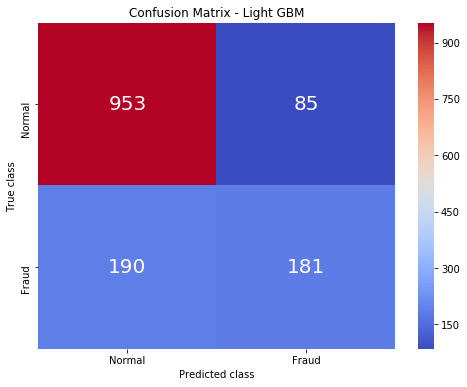

In [165]:
conf_matrix = confusion_matrix(yv, pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], 
            cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion Matrix - Light GBM")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

This is telling us that we predicted 266 cases of customer churn, which 181 of which is actual churn.

With this model, generally speaking, we missed many instances of customer churn (190) and we incorrectly identified 85 instances that were not customer churn. So, this model could definitely use some improvements if implemented this way.

But what if we were to base it on probability of churn with a particular threshold maximizing our F1 score?

In [171]:

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [173]:
th_sr = threshold_search(yv, ppreds[:,1])
print("Threshold Search F1 Result :")
print(th_sr)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\schillw\AppData\Local\Continuum\anaconda3\envs\fnb\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1926.94it/s]


Threshold Search F1 Result :
{'f1': 0.50428163653663172, 'threshold': 0.26}


Based on a probability threshold of 0.26, we can achieve an F1 score of 0.504. Which in all, is still not as high as we would hope. 
We would likely try a different set of modeling techniques and possibly other feature creation from this point.

In [174]:
def prob_to_bool(x, threshold=0.5):
    #function for thesholding predictions if less than 0.5
    x_bool = x>=threshold
    return x_bool

In [175]:
final_pred = prob_to_bool(ppreds[:,1], threshold=0.26)

In [176]:
print(classification_report(final_pred, yv))

             precision    recall  f1-score   support

      False       0.60      0.85      0.71       729
       True       0.71      0.39      0.50       680

avg / total       0.66      0.63      0.61      1409



Here we improved our precision quite a bit bit lost a lot in recall and the damage is quite evident in the number of cases that were not customer churn but were identified as such (415). We definitely grabbed many more correct cases but at a cost.

This could have potentially been a lot of resources/money chasing these down when we could have been focusing on the 106 that we did not get. 

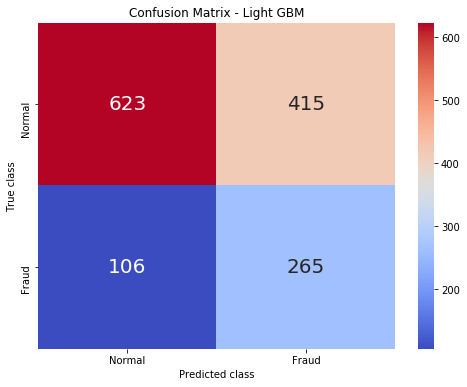

In [177]:
conf_matrix = confusion_matrix(yv, final_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], 
            cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion Matrix - Light GBM")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Feature Importance Examinination

In [153]:
fi_df = pd.DataFrame(100*modrf.feature_importances_.T/modrf.feature_importances_.max(), 
                     index=X.columns, 
                     columns=['importance']).sort_values(by='importance', ascending=True)

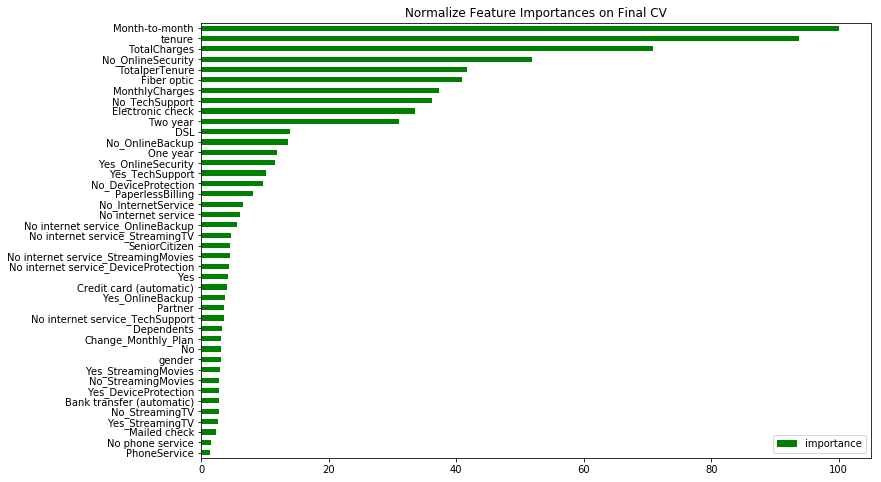

In [155]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
fi_df.plot(kind='barh', ax=ax, color='g');
plt.title("Normalize Feature Importances on Final CV");

In [157]:
fi_df_acc = pd.DataFrame(100*fis.T/fis.max()/folds, 
                     index=X.columns, 
                     columns=['importance']).sort_values(by='importance', ascending=True)

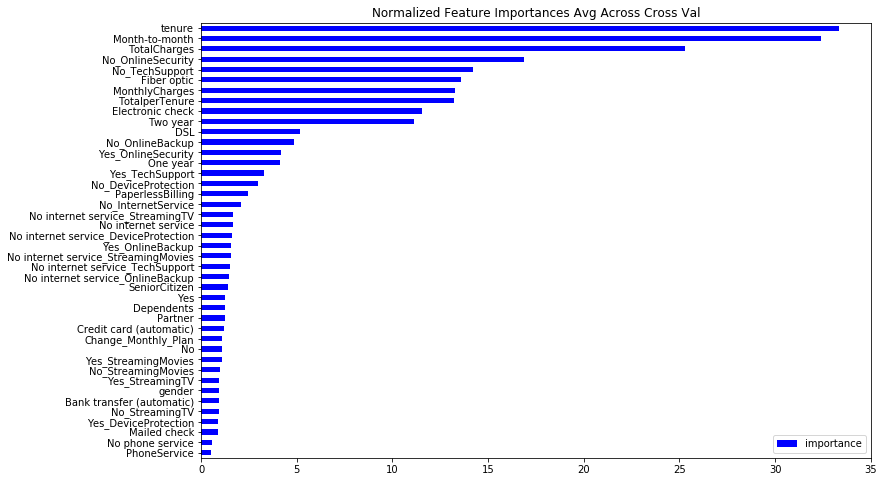

In [158]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
fi_df_acc.plot(kind='barh', ax=ax, color='b');
plt.title("Normalized Feature Importances Avg Across Cross Val");

In either case, the top 5 contributors appears to be:
- tenure
- Month-to-Month status
- TotalCharges
- No Online Security
- No Tech Support
- Total per Tenure